In [1]:
# core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as pjoin

from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 500

In [2]:
data_path = pjoin('..', 'data')
df_train = pd.read_csv(pjoin(data_path, 'train_eng.csv'), engine='c')
df_test = pd.read_csv(pjoin(data_path, 'test_eng.csv'), engine='c')

# ignore_index from previous savings
#df_train = df_train[df_train.columns[1:]]
#df_test = df_test[df_test.columns[1:]]

In [3]:
for df in [df_train, df_test]:
    df['StartOfferDate'] = pd.to_datetime(df['StartOfferDate'])
    df['StartDateCorrection'] = pd.to_datetime(df['StartDateCorrection'], 
                                               errors='coerce')
    df['EndDate'] = pd.to_datetime(df['EndDate'])
    df['EndOfferDate'] = pd.to_datetime(df['EndOfferDate'])

In [4]:
df_train['train_val'] = np.where(
    (df_train.EndDate > "2017-06-30")  
    & (df_train.LotStatus == 'Завершено лот закупівлі') 
    & (df_train.TenderStatus=='complete'), 
    'val', 
    'train'
)

In [5]:
df_train.set_index('unique_id', inplace=True)
df_test.set_index('unique_id', inplace=True)

df_train = df_train[[c for c in df_train.columns if c in df_test.columns] + ['train_val']]

df_train_grouped = df_train.groupby(df_train.index).head(1).sort_index()
df_train_grouped['counts'] = df_train.groupby(df_train.index).size().sort_index()

## Geo + Categorical

In [6]:
# encode categorical features INPLACE!
def __encode_categorical(df_list, cat_cols):
    # encode categorical data
    d = defaultdict(LabelEncoder)

    # fit and encode train/test
    a = pd.concat([df[cat_cols] for df in df_list], axis=0).fillna('').apply(
        lambda x: d[x.name].fit(x))
    # transform encodings to train/test
    for df in df_list:
        df[cat_cols] = df[cat_cols].fillna('').apply(lambda x: d[x.name].transform(x))

        
# example usage:
# features_categorigal = ['TypeOrginizer', 'TypeMethod']
# encode_categorical(df_list, features_categorigal)
        

# GEO FEATURES -------------------------------------------------

# create mapping dict
geo_mapping_coord = pd.DataFrame(
{ 
    # '6 chars lowercased': (LabelEncoder ID, lat, long)
    'київсь':     (1, 50.4021368,30.2525113),
    'дніпро':     (2, 48.4624412,34.8602734),
    'донець':     (3, 47.9902621,37.6214375),
    'вінниц':     (4, 49.2348249,28.3995942),
    'запорі':     (5, 47.8563742,35.0352705),
    'львівс':     (6, 49.8327787,23.9421959),
    'черніг':     (7, 51.495866,31.2204989),
    'одеськ':      (8, 46.460123,30.5717042),
    'харків':      (9, 49.9947277,36.1457419),
    'житоми':      (10, 50.2679751,28.6036779),
    'микола':      (11, 46.9332135,31.8679138),
    'сумськ':      (12, 50.9007528,34.7441743),
    'волинс':      (13, 50.7398786,25.2639652),
    'полтав':      (14, 49.6021346,34.4871989),
    'хмельн':      (15, 49.4106425,26.9252189),
    'івано-':      (16, 48.9118242,24.6821096),
    'черкас':      (17, 49.4312235,31.9791903),
    'рівнен':      (18, 50.6111564,26.1745436),
    'луганс':      (19, 48.5802062,39.2168845),
    'терноп':      (20, 49.5484448,25.5276293),
    'херсон':      (21, 46.6496689,32.5377419),
    'кірово':      (22, 48.518858,32.1456233),
    'чернів':      (23, 51.495866,31.2204989),
    'закарп':      (24, 48.496582,22.8212266),
    'украин':      (25, 48.2559613,26.6958946),# украина
    'відпов':      (26, 0, 0),# відповідно документу
    'others':       (-1, 0, 0), # missing / other
}).T

geo_mapping_coord.columns = ['LabelEncoderID', 'lat', 'long']


# pass grouped (train/test) dataframes
# geo_mapping_df == geo_mapping_coord
def __create_geo_features(df, geo_mapping_df):
    
    df_geo = df.reset_index()[[
        'unique_id', 
        'DeliveryRegion', 
        'OrgRegion'
    ]].copy(deep=True)
    
    
    # 1. DeliveryRegion
    # clean some garbage (heuristics)

    # strip and lowercase, take 6 first chars
    df_geo.loc[df_geo.DeliveryRegion == '-', 'DeliveryRegion'] = 'others'
    df_geo.DeliveryRegion = df_geo.DeliveryRegion.str.strip()\
    .str.lower().str[:6]

    df_geo.loc[df_geo.DeliveryRegion == 'одесск', 
                         'DeliveryRegion'] = 'одеськ'
    df_geo.loc[df_geo.DeliveryRegion == 'украин', 
                         'DeliveryRegion'] = 'україн'

    df_geo.loc[df_geo.DeliveryRegion == 'харько', 
                         'DeliveryRegion'] = 'харків'

    true_regions = set(geo_mapping_df.index.values.tolist())

    # fill-in all other
    df_geo.loc[
        ~df_geo.DeliveryRegion.isin(true_regions), 
        'DeliveryRegion'
    ] = 'others'

    # estimate garbage/missing percent
    print('garbage/missing %: {:.2f}'.format(
        df_geo[df_geo.DeliveryRegion == 'others'].shape[0] / 
        df_geo.shape[0]
    ))
    
    # 2. OrgRegions
    # replace missing and clean data
    df_geo.loc[df_geo.OrgRegion == '-', 'OrgRegion'] = 'others'
    df_geo.OrgRegion = df_geo.OrgRegion.str[:6].str.lower()
    
    # add lat/long
    
    df_geo['OrgRegion_lat'] = df_geo.OrgRegion.map(geo_mapping_df['lat']).fillna(0)
    df_geo['OrgRegion_long'] = df_geo.OrgRegion.map(geo_mapping_df['long']).fillna(0)
    
    df_geo['DeliveryRegion_lat'] = df_geo.DeliveryRegion.map(
        geo_mapping_df['lat']).fillna(0)
    df_geo['DeliveryRegion_long'] = df_geo.DeliveryRegion.map(
        geo_mapping_df['long']).fillna(0)
    
    # cnange strings to label encoded
    df_geo.OrgRegion = df_geo.OrgRegion.map(
        geo_mapping_df['LabelEncoderID']).fillna(-1)
    df_geo.DeliveryRegion = df_geo.DeliveryRegion.map(
        geo_mapping_df['LabelEncoderID']).fillna(-1)
    
    # check is equal
    df_geo['DeliveryOrg_isequal'] = (df_geo.OrgRegion == df_geo.DeliveryRegion)
    
    
    # return distance for non-equal
    df_geo['DeliveryOrg_distance'] = -1
    df_geo.loc[~df_geo.DeliveryOrg_isequal, 'DeliveryOrg_distance'] = \
    df_geo.loc[~df_geo.DeliveryOrg_isequal, 
              ].apply(
        lambda x: np.linalg.norm(
            np.array([x['DeliveryRegion_lat'],x['DeliveryRegion_long']]) 
            - np.array([x['OrgRegion_lat'],x['OrgRegion_long']]))
    , axis=1
    )
    
    return df.drop(['DeliveryRegion', 'OrgRegion'], axis=1, errors='ignore').merge(
            right=df_geo.set_index('unique_id'),
            left_index=True,
            right_index=True
    )


def add_cat_and_geo_features(df_list, cat_cols, geo_mapping_df):
    
    # perform categorical encoding inplace
    __encode_categorical(df_list, cat_cols)
    
    # process geo-features and concat it with the initial df for each df in list
    df_list = [__create_geo_features(df, geo_mapping_df) for df in df_list]
    
    return df_list

## CPV features

In [7]:
def strip(x, n):
    return x.strip()[:n].strip()


def add_CPV_features(df, split_type=2):
    
    df['CPV2017'] = df['CPV2017'].apply(lambda x: '00000000-0'
                                        if strip(x, 10) == '-' else x)

    if split_type == 1:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: int(x.strip()[:2]))
        df['CPV_group'] = df['CPV2017'].apply(lambda x: int(x.strip()[2:3]))
        df['CPV_class'] = df['CPV2017'].apply(lambda x: int(x.strip()[3:4]))
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: int(x.strip()[4:5]))
    else:
        df['CPV_unit'] = df['CPV2017'].apply(lambda x: int(x.strip()[:2]))
        df['CPV_group'] = df['CPV2017'].apply(lambda x: int(x.strip()[:3]))
        df['CPV_class'] = df['CPV2017'].apply(lambda x: int(x.strip()[:4]))
        df['CPV_cat'] = df['CPV2017'].apply(lambda x: int(x.strip()[:5]))

    df['CPV_desc'] = df['CPV2017'].apply(lambda x: x[11:])
    df['CPV_desc'] = df['CPV_desc'].apply(
        lambda x: "NO DESC" if len(x.strip()) < 2 else x)

    df['Organizer'] = df['Organizer'].apply(lambda x: x.lower())
    df['Organizer_railroad'] = df['Organizer'].apply(
        lambda x: 1 if 'залізниц' in x else 0)
    df['Organizer_ministry'] = df['Organizer'].apply(
        lambda x: 1 if 'міністерств' in x else 0)
    df['Organizer_komun'] = df['Organizer'].apply(
        lambda x: 1 if 'комунальне підприємство'
        in x else 0)
    df['Organizer_edu'] = df['Organizer'].apply(
        lambda x: 1 if 'освіт' in x else 0)

    return df

## Numerical Features

In [8]:
import scipy.stats as spstats

features_numerical = ['GuaranteeValueLot', 'StepDecreaseLot', 'SumTender']


def boxcox_feature(feature_name, df):

    feature_np = np.array(df[feature_name])
    feature_np_clean = feature_np[~np.isnan(feature_np)]
    l, opt_lambda = spstats.boxcox(feature_np_clean)
    df[feature_name+'_0'] = spstats.boxcox(
        (1+df[feature_name]),
        lmbda=0)
    df[feature_name+'_0'] = df[feature_name+'_0'].fillna(0.0)
    df[feature_name+'_boxcox_lambda_opt'] = spstats.boxcox(
        df[feature_name], lmbda=opt_lambda)
    df[feature_name+'_boxcox_lambda_opt'] = df[feature_name +
                                               '_boxcox_lambda_opt'].fillna(0.0)
    return df


# just feed df with eng columns
def transfrom_numerical(df, features_numerical):
    for feature in features_numerical:
        df[feature] = df[feature].apply(pd.to_numeric, errors='coerce')
    df[features_numerical] = df[features_numerical].fillna(0)
    for feature in features_numerical:
        df[feature +
            '_isZero'] = df[feature].apply(lambda x: 1 if x == 0.0 else 0)
    df[features_numerical] = df[features_numerical].replace(0.0, np.nan)
    for feature in features_numerical:
        df = boxcox_feature(feature, df)
    #df = df.drop(columns=features_numerical)
    return df

## Date features

In [9]:
def get_date_features(df, date_columns):
    for c in date_columns:
        df[c + '_year'] = df[c].dt.year
        df[c + '_month'] = df[c].dt.month
        df[c + '_dow'] = df[c].dt.dayofweek
    
    return df

    
# add date features
date_columns = ['StartOfferDate']
for df in [df_train_grouped, df_test]:
    df = get_date_features(df, date_columns)
print(df_train_grouped.shape, df_test.shape)

(500037, 26) (75969, 24)


In [10]:
def get_date_diff(df, date1, date2):
    df[date1+'_diff_'+date2] = (df[date1]-df[date2])/np.timedelta64(1, 'D')
    return df

for df in [df_train_grouped, df_test]:
    df = get_date_diff(df, 'EndOfferDate', 'StartOfferDate' )
    df = get_date_diff(df, 'EndDate', 'StartDateCorrection' )
    df = get_date_diff(df, 'EndDate', 'EndOfferDate' )
    df = get_date_diff(df, 'StartOfferDate', 'StartDateCorrection' )
print(df_train_grouped.shape, df_test.shape)

(500037, 30) (75969, 28)


In [11]:
df_test.columns

Index(['Unnamed: 0', 'CPV2017', 'SumTender', 'Organizer', 'ID', 'IDLOT',
       'StartOfferDate', 'TypeMethod', 'TypeOrginizer', 'LotStatus',
       'TenderStatus', 'OrgRegion', 'DeliveryRegion', 'Tender',
       'StartDateCorrection', 'LotDescr', 'IDOrganizator', 'EndDate',
       'EndOfferDate', 'StepDecreaseLot', 'GuaranteeValueLot',
       'StartOfferDate_year', 'StartOfferDate_month', 'StartOfferDate_dow',
       'EndOfferDate_diff_StartOfferDate', 'EndDate_diff_StartDateCorrection',
       'EndDate_diff_EndOfferDate', 'StartOfferDate_diff_StartDateCorrection'],
      dtype='object')

In [12]:
%%time

# add geo + encode categorical
print(df_train_grouped.shape, df_test.shape)
cat_cols = ['TypeOrginizer', 'TypeMethod']
df_train_grouped, df_test = add_cat_and_geo_features([df_train_grouped, df_test], cat_cols, geo_mapping_coord)
print(df_train_grouped.shape, df_test.shape)

# add cpv features
for df in [df_train_grouped, df_test]:
    df = add_CPV_features(df)
print(df_train_grouped.shape, df_test.shape)

# add and transform numericals
for df in [df_train_grouped, df_test]:
    df = transfrom_numerical(df, features_numerical=features_numerical)
print(df_train_grouped.shape, df_test.shape)

(500037, 30) (75969, 28)
garbage/missing %: 0.02
garbage/missing %: 0.02
(500037, 36) (75969, 34)
(500037, 45) (75969, 43)


/Users/jenya/miniconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:1030: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


(500037, 54) (75969, 52)
CPU times: user 36.3 s, sys: 1.21 s, total: 37.5 s
Wall time: 37.7 s


### Add complaints feature(s)

In [13]:
train = df_train_grouped[df_train_grouped.train_val=='train']
val = df_train_grouped[df_train_grouped.train_val=='val']

In [ ]:
df_complaints = pd.read_csv(pjoin(data_path, 'complaints_train.csv'), engine='c')
df_complaints.columns = [
    'complainer',
    'Organizator',
    'complain_city',
    'ID',
    'IDLOT',
    'complain_tender',
    'complain_status',
    'complain_type',
    'complain_file_date',
    'complain_description',
    'complain_date',
    'unique_id',
]

# drop "garbage"
print(df_complaints.shape)
df_complaints = df_complaints[~df_complaints.complain_date.str.contains('-')]
print(df_complaints.shape)

df_complaints.complain_date = pd.to_datetime(
    df_complaints.complain_date, format='%d.%m.%Y'
)

df_complaints['IDOrganizator'] = df_complaints.unique_id.map(
              df_train_grouped.IDOrganizator
).astype(np.int32)

compl_by_org = df_complaints.groupby('IDOrganizator').agg(
    {
        'unique_id': lambda x: len(np.unique(x)),
    })

compl_by_org['lots_in_train'] = df_train_grouped[df_train_grouped.train_val == 'train'].reset_index().groupby('IDOrganizator').agg(
    {
        'unique_id': lambda x: len(np.unique(x)),
    }).unique_id

# filter, non-future
df_complaints = df_complaints[df_complaints.complain_date < "2017-06-30"]

compl_by_org['lot_complain_ratio'] = (
    compl_by_org['unique_id'] / compl_by_org['lots_in_train']
).fillna(0).astype(np.float32)

compl_by_org.loc[compl_by_org.lot_complain_ratio > 1, 'lot_complain_ratio'] = 1

train['lot_complain_ratio'] = train.IDOrganizator.map(
    compl_by_org.lot_complain_ratio).fillna(0)
val['lot_complain_ratio'] = val.IDOrganizator.map(
    compl_by_org.lot_complain_ratio).fillna(0)
df_test['lot_complain_ratio'] = df_test.IDOrganizator.map(
    compl_by_org.lot_complain_ratio).fillna(0)
    
print(train.shape, val.shape, df_test.shape)

---

In [14]:
train['LotStatus'].value_counts()

Завершено лот закупівлі     223891
Неуспішний лот закупівлі    169753
Скасовано лот закупівлі      33134
Активний лот закупівлі       10272
Name: LotStatus, dtype: int64

In [15]:
train['TenderStatus'].value_counts()

complete                                238505
unsuccessful                            155343
cancelled                                32550
active.awarded                            9112
active.qualification                      1464
active.tendering                            53
active.pre-qualification                    18
active.pre-qualification.stand-still         5
Name: TenderStatus, dtype: int64

In [16]:
train = train[train['LotStatus'] == 'Завершено лот закупівлі'][train['TenderStatus'] == 'complete']

/Users/jenya/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


## Organizators features

In [17]:
train_all = pd.read_csv('train_cv.csv')

In [18]:
train_small_all = train_all[train_all['train_val'] == 'train']

In [19]:
org_complaints = pd.read_csv('org_complaints.csv')
org_complaints.set_index('Organizator', inplace=True)
org_complaints = org_complaints.to_dict()['complaints']

In [20]:
organizator_lots_count = dict(train['IDOrganizator'].value_counts())
organizator_props_count = {}
organizator_participant_count = {}
organizator_ratio = {}
for org_name, org_data in train_small_all.groupby('IDOrganizator'):    
    organizator_props_count[org_name] = len(org_data)
    organizator_participant_count[org_name] = len(org_data['Participant'].unique().tolist())
    organizator_ratio[org_name] = organizator_participant_count[org_name] / organizator_props_count[org_name]

In [21]:
def get_organizator_lots_count(id_organizator):
    if id_organizator in organizator_lots_count:
        return np.log(organizator_lots_count[id_organizator])
    else:
        return 0
def get_organizator_props_count(id_organizator):
    if id_organizator in organizator_props_count:
        return np.log(organizator_props_count[id_organizator])
    else:
        return 0
def get_organizator_participant_count(id_organizator):
    if id_organizator in organizator_participant_count:
        return np.log(organizator_participant_count[id_organizator])
    else:
        return 0
def get_organizator_ratio(id_organizator):
    if id_organizator in organizator_ratio:
        return organizator_ratio[id_organizator]
    else:
        return 0
    
def get_org_complaints(id_organizator):
    if id_organizator in org_complaints:
        return np.log(org_complaints[id_organizator])
    else:
        return 0

In [22]:
train['organizator_lots_count'] = train['IDOrganizator'].map(get_organizator_lots_count)
# train['organizator_props_count'] = train['IDOrganizator'].map(get_organizator_props_count)
# train['organizator_participant_count'] = train['IDOrganizator'].map(get_organizator_participant_count)
# train['organizator_ratio'] = train['IDOrganizator'].map(get_organizator_ratio)
# train['org_complaints'] = train['Organizer'].map(get_org_complaints)
# train['org_complaints_ratio'] = train['org_complaints'].astype('float') / train['organizator_lots_count'].astype('float').fillna(0)


val['organizator_lots_count'] = val['IDOrganizator'].map(get_organizator_lots_count)
# val['organizator_props_count'] = val['IDOrganizator'].map(get_organizator_props_count)
# val['organizator_participant_count'] = val['IDOrganizator'].map(get_organizator_participant_count)
# val['organizator_ratio'] = val['IDOrganizator'].map(get_organizator_ratio)
# val['org_complaints'] = val['Organizer'].map(get_org_complaints)
# val['org_complaints_ratio'] = val['org_complaints'].astype('float') / val['organizator_lots_count'].astype('float').fillna(0)

/Users/jenya/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
organiztor_lots_count_test = dict(df_train_grouped['IDOrganizator'].value_counts())
def organizator_popularity_test(id_organizator):
    if id_organizator in organiztor_lots_count_test:
        return np.log(organiztor_lots_count_test[id_organizator])
    else:
        return 0
df_test['organizator_lots_count'] = df_test['IDOrganizator'].map(organizator_popularity_test)

## Text features

In [24]:
## Linear
text_features = pd.read_csv('../data/text_prediction.csv')
text_features_test = pd.read_csv('../data/text_prediction_test.csv')

## NN
text_nn_features = pd.read_csv('../data/text_nn_prediction.csv')
text_nn_features_test = pd.read_csv('../data/text_nn_prediction_test.csv')

In [25]:
train = train.reset_index()
val = val.reset_index()
df_test = df_test.reset_index()

In [26]:
train = train.merge(text_features, on='unique_id')
val = val.merge(text_features, on='unique_id')

In [27]:
train = train.merge(text_nn_features, on='unique_id')
val = val.merge(text_nn_features, on='unique_id')

In [28]:
df_test = df_test.merge(text_features_test, on='unique_id')
df_test = df_test.merge(text_nn_features_test, on='unique_id')

In [29]:
# train['pred_nn_kvadrat'] = train['prediction_text_nn']*train['EndDate_diff_StartDateCorrection']
# train['pred_nn_koob'] = train['prediction_text_nn']*train['TypeMethod']
# val['pred_nn_kvadrat'] = val['prediction_text_nn']*val['EndDate_diff_StartDateCorrection']
# val['pred_nn_koob'] = val['prediction_text_nn']*val['TypeMethod']
# df_test['pred_nn_kvadrat'] = df_test['prediction_text_nn']*df_test['EndDate_diff_StartDateCorrection']
# df_test['pred_nn_koob'] = df_test['prediction_text_nn']*df_test['TypeMethod']

def get_cummulative(df1, df2, df3, feature, df_calc = train):
    x = df_calc[[feature, 'StartDateCorrection', 'counts']].groupby([feature, 'StartDateCorrection']).sum().shift().groupby(level = [0]).cumsum().reset_index()
    y = df_calc[[feature, 'StartDateCorrection', 'counts']].groupby([feature, 'StartDateCorrection']).sum().groupby(level = [0]).cumcount().reset_index()
    x = pd.merge(x, y)

    x['mean'] = x.counts/(x[0])
    x.replace([np.inf], np.nan, inplace = True)#.
    x.dropna(subset=['mean'], inplace = True)
    x.drop([0], axis = 1, inplace = True)
    x.columns.values[2]=feature+'_total'
    x.columns.values[3]=feature+'_mean'
    
    y = train[[feature, 'counts']].groupby(feature).agg({'counts': [sum, np.mean]})
    y.columns = y.columns.droplevel()
    y = y.reset_index()
    y.columns.values[1] = feature+'_total'
    y.columns.values[2] = feature+'_mean'
    
    return pd.merge(df1, x, 'left'), pd.merge(df2, y, 'left'), pd.merge(df3, y, 'left')

features_to_get = ['CPV_unit', 'IDOrganizator', 'OrgRegion', 'DeliveryRegion']
for feat in features_to_get:
    train, val, df_test = get_cummulative(train, val, df_test, feat, df_calc = train)

## Classifier features

In [30]:
knn_features = pd.read_csv('../data/knn_0330_train.csv')
# text_features_test = pd.read_csv('../data/text_prediction_test.csv')
knn_features.rename(columns={'target': 'knn'}, inplace=True)

In [31]:
train = train.merge(knn_features, on='unique_id')
val = val.merge(knn_features, on='unique_id')

## LightGBM

In [32]:
train.columns

Index(['unique_id', 'Unnamed: 0', 'CPV2017', 'SumTender', 'Organizer', 'ID',
       'IDLOT', 'StartOfferDate', 'TypeMethod', 'TypeOrginizer', 'LotStatus',
       'TenderStatus', 'Tender', 'StartDateCorrection', 'LotDescr',
       'IDOrganizator', 'EndDate', 'EndOfferDate', 'StepDecreaseLot',
       'GuaranteeValueLot', 'train_val', 'counts', 'StartOfferDate_year',
       'StartOfferDate_month', 'StartOfferDate_dow',
       'EndOfferDate_diff_StartOfferDate', 'EndDate_diff_StartDateCorrection',
       'EndDate_diff_EndOfferDate', 'StartOfferDate_diff_StartDateCorrection',
       'DeliveryRegion', 'OrgRegion', 'OrgRegion_lat', 'OrgRegion_long',
       'DeliveryRegion_lat', 'DeliveryRegion_long', 'DeliveryOrg_isequal',
       'DeliveryOrg_distance', 'CPV_unit', 'CPV_group', 'CPV_class', 'CPV_cat',
       'CPV_desc', 'Organizer_railroad', 'Organizer_ministry',
       'Organizer_komun', 'Organizer_edu', 'GuaranteeValueLot_isZero',
       'StepDecreaseLot_isZero', 'SumTender_isZero', 'Guaran

In [42]:
features = []

# features += ['TenderStatus', 'LotStatus']

features += ['TypeMethod', 'TypeOrginizer']

features += ['OrgRegion', 'DeliveryRegion']
features += ['DeliveryOrg_isequal']
features += ['DeliveryOrg_distance']

features += ['GuaranteeValueLot_isZero', 'StepDecreaseLot_isZero',
       'SumTender_isZero']
features += ['GuaranteeValueLot_0', 'StepDecreaseLot_0', 'SumTender_0']
# features = ['GuaranteeValueLot_boxcox_lambda_opt', 'StepDecreaseLot_boxcox_lambda_opt', 'SumTender_boxcox_lambda_opt']

features += ['Organizer_railroad', 'Organizer_ministry', 'Organizer_komun', 'Organizer_edu']
features += ['CPV_unit', 'CPV_group', 'CPV_class','CPV_cat']

features += ['prediction_Tender', 'prediction_LotDescr', 'prediction_Organizer', 'prediction_CPV_desc']
features += ['prediction_text_nn']

features += ['organizator_lots_count']
# features += ['org_complaints_ratio']
# features += ['organizator_ratio']
# features += ['organizator_props_count', 'organizator_participant_count']

features += ['StartOfferDate_year',
       'StartOfferDate_month', 'StartOfferDate_dow',]
features += [ 'EndOfferDate_diff_StartOfferDate', 'EndDate_diff_StartDateCorrection',
            'EndDate_diff_EndOfferDate', 'StartOfferDate_diff_StartDateCorrection']
#features +=['CPV_unit_mean']#, 'IDOrganizator_mean',]
       #'OrgRegion_mean', 'DeliveryRegion_mean']

#classifier 
# features += [str(i) for i in range(18)]
# features += ['knn']

# add complaints (new)
features += ['lot_complain_ratio']

In [43]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

lgbm_params = {    
#     'learning_rate': 0.15,
#     'objective':'poisson',
#     'max_depth': 13,
#     'num_leaves': 400,
#     'verbosity': -1,
#     'metric': 'RMSE',
#     'data_random_seed': 1,
#     'bagging_fraction': 0.8,
#     'feature_fraction': 0.6,
#     'nthread': 4,
#     'lambda_l1': 10,
#     'lambda_l2': 10
    
    
     'application': 'poisson',
       'num_leaves': 127, # was 127
       'learning_rate': 0.15, # was 0.02
       'max_depth': 11, # was 7

       'min_child_samples': 60,
       'metric': 'rmse',

       'feature_fraction': 0.8, # was 0.7
       'sub_row': 0.75, # was 0.7
       'num_threads': -1,
       'verbose': 0,
       'seed': 42,
    
}

# lgbm_params = {
    
#     'application': 'poisson',
#    'num_leaves': 127,
#    'learning_rate': 0.15, 
#    'max_depth': 11,

#    'min_child_samples': 60,
#    'metric': 'rmse',
    
#    'feature_fraction': 0.8,
#    'sub_row': 0.75,
#    'num_threads': -1,
#    'verbose': 0,
#    'seed': 42,
#     'lambda_l2': 2.5,
#     'lambda_l1': 0.5,
# }


def rmsle(y_true,y_pred):
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

def rmsle_lgb(preds, df):
    labels = df.get_label()
    return 'rmsle', rmsle(labels, preds), False

In [44]:
x_train = train[features]
y_train = np.log1p(train['counts'])
# y_train = train['counts']

x_test = val[features]
y_test = np.log1p(val['counts'])
# y_test = val['counts']

In [45]:
lgb_train = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
lgb_val = lgb.Dataset(x_test, label=y_test, free_raw_data=False, reference=lgb_train)

model = lgb.train(lgbm_params, lgb_train, 1000, valid_sets=[lgb_train,lgb_val], early_stopping_rounds=40)

[1]	training's rmse: 0.376853	valid_1's rmse: 0.357838
Training until validation scores don't improve for 40 rounds.
[2]	training's rmse: 0.368779	valid_1's rmse: 0.34967
[3]	training's rmse: 0.361836	valid_1's rmse: 0.342669
[4]	training's rmse: 0.357276	valid_1's rmse: 0.338088
[5]	training's rmse: 0.35315	valid_1's rmse: 0.334021
[6]	training's rmse: 0.349762	valid_1's rmse: 0.330736
[7]	training's rmse: 0.346877	valid_1's rmse: 0.327965
[8]	training's rmse: 0.342656	valid_1's rmse: 0.323967
[9]	training's rmse: 0.339064	valid_1's rmse: 0.320541
[10]	training's rmse: 0.335951	valid_1's rmse: 0.317651
[11]	training's rmse: 0.333246	valid_1's rmse: 0.315205
[12]	training's rmse: 0.330892	valid_1's rmse: 0.313121
[13]	training's rmse: 0.329553	valid_1's rmse: 0.312034
[14]	training's rmse: 0.327658	valid_1's rmse: 0.310456
[15]	training's rmse: 0.326025	valid_1's rmse: 0.309071
[16]	training's rmse: 0.324971	valid_1's rmse: 0.308243
[17]	training's rmse: 0.323654	valid_1's rmse: 0.3071

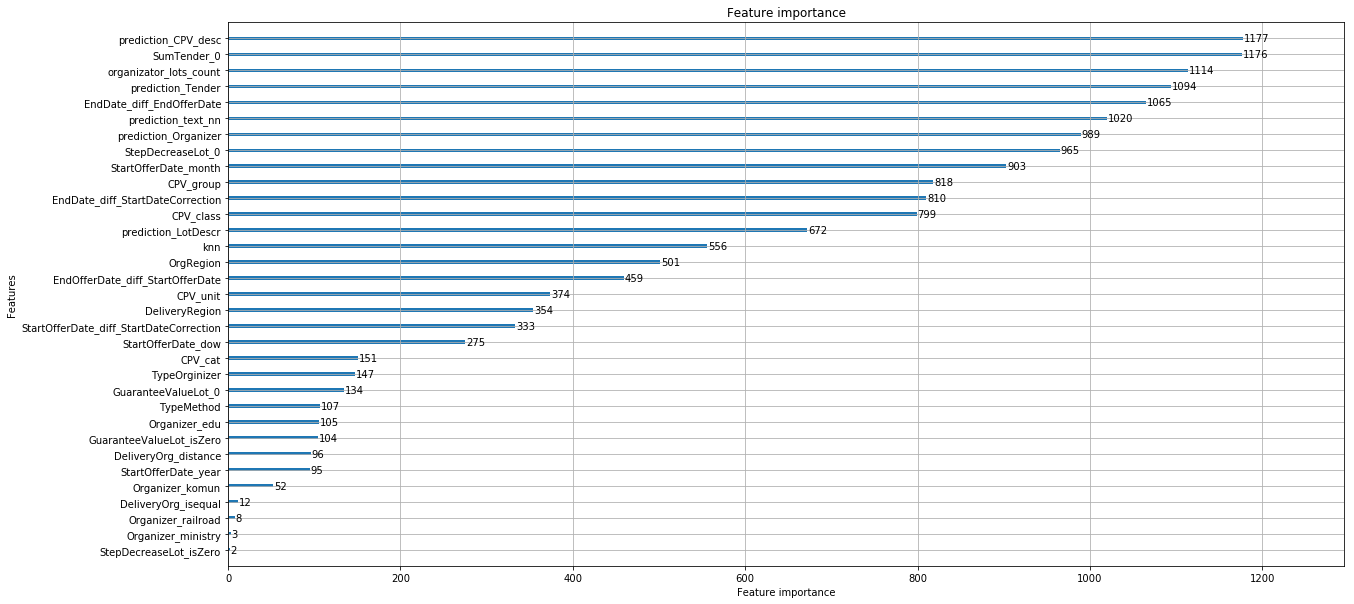

In [39]:
lgb.plot_importance(model, figsize=(20, 10))

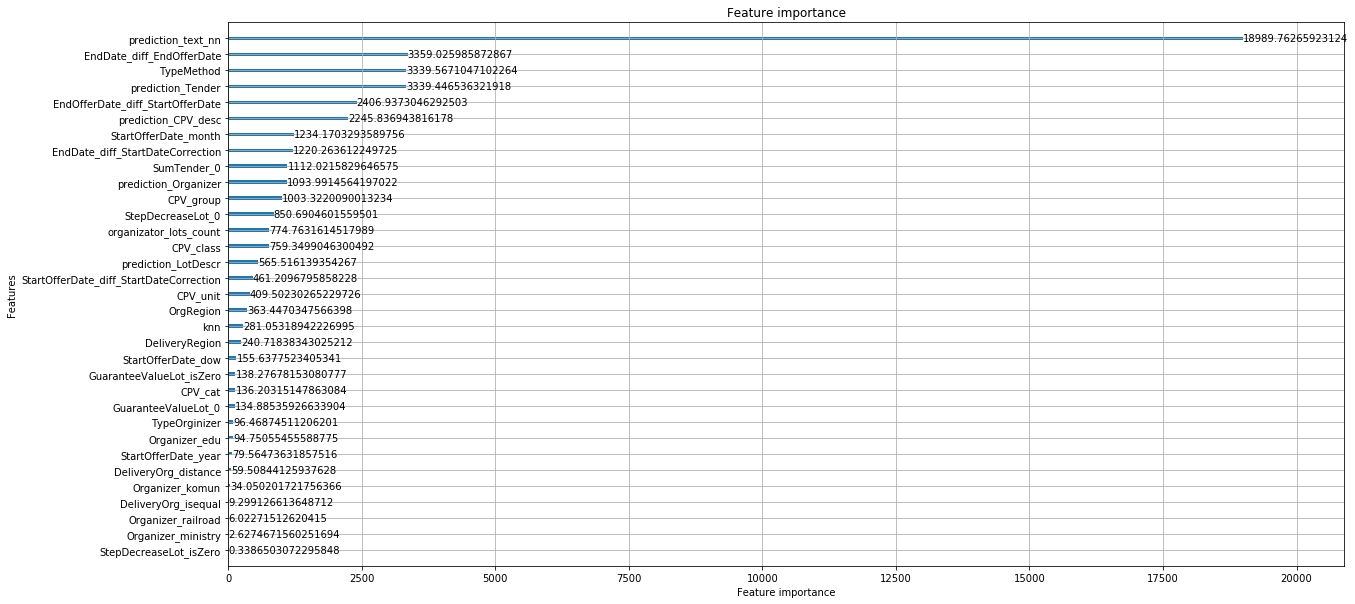

In [40]:
lgb.plot_importance(model, figsize=(20, 10), importance_type='gain')

## Make submission

In [52]:
final_preds = model.predict(df_test[features])

In [53]:
df_test['target'] = np.exp(final_preds) - 1

In [54]:
df_test[['unique_id','target']].to_csv('lb_0_29.csv', index=False)

In [55]:
pd.read_csv('lb_0_29.csv')

unique_id  \
0         47ed5cbfe2e44cb089c7879722fbe3f4_e15fc7eace2cc071490ac3c8aaaea261   
1         f9a1a6499cf04091a149c5f82c652d2f_6f5a9384547f229e259fe673473d8d2b   
2         bf779f5547cb43f3a3c8014fa8c3a6ca_f7efe9cbc9ca0fe18cebdebb0b1b1084   
3         8bdf2c96ddf047538c93b0f4c763f895_e91eeaff5e455f1185a1d6ef5eabaf7e   
4         ccc361524d9e4743ab0a72eb47b3be44_173e4adae55dc3f0d5009780161450ab   
5      7de6cb883c654275b45f637c1a2653b4_Lot7de6cb883c654275b45f637c1a2653b4   
6      ca3f2277de664cd0a88a5bfa53aadd25_Lotca3f2277de664cd0a88a5bfa53aadd25   
7      4a77f813c3b84dc9a059fbf7fbec7250_Lot4a77f813c3b84dc9a059fbf7fbec7250   
8      e0358a25270740da950071d3a9746ddf_Lote0358a25270740da950071d3a9746ddf   
9      a51eb34fc5ec49ad99f565cf732dba74_Lota51eb34fc5ec49ad99f565cf732dba74   
10     c83b05797a4a45599f68ac61633c5487_Lotc83b05797a4a45599f68ac61633c5487   
11     0e0548046e2449b8877357510cefcf95_Lot0e0548046e2449b8877357510cefcf95   
12     4c7ad7f66ad141f4be6ac1408fd3e0e3_Lot4c7ad7f66ad141f4be6ac1408fd3e0e3   
13     0865dd1140744fe694df25c5df4347e4_Lot0865dd1140744fe694df25c5df4347e4   
14     9ec32be6e6744b90ae3c684008afd66b_Lot9ec32be6e6744b90ae3c684008afd66b   
15     c718a667547545a2b31a5a2a89d571b4_Lotc718a667547545a2b31a5a2a89d571b4   
16     3ad23b3e6cb642898d924b56e6e488dc_Lot3ad23b3e6cb642898d924b56e6e488dc   
17     103ee604063e43a39fcfc5fdb98aa8b7_Lot103ee604063e43a39fcfc5fdb98aa8b7   
18     15ac19d63a6446ef95cacb6ad4b680fe_Lot15ac19d63a6446ef95cacb6ad4b680fe   
19     841ea9a7f21647b0b548734010f917fa_Lot841ea9a7f21647b0b548734010f917fa   
20     a2fda47417744db0bc2b1a97b65f3359_Lota2fda47417744db0bc2b1a97b65f3359   
21     70c1a75ec56c4a97b40d030bfd1183a4_Lot70c1a75ec56c4a97b40d030bfd1183a4   
22     11975cc1a02e4a4a9054932e4fe7ac00_Lot11975cc1a02e4a4a9054932e4fe7ac00   
23     db2b5035ddad40449d3d455e38412d1c_Lotdb2b5035ddad40449d3d455e38412d1c   
24     93a28dc3eadc49db9f1bccb6aca961b3_Lot93a28dc3eadc49db9f1bccb6aca961b3   
25        24e1b6a9b1e744f5b9b2c4cb1f64599b_15d162cf4fa84f10bc190a7e9cd55ca3   
26     2a55933e6377437994a0c4752737c975_Lot2a55933e6377437994a0c4752737c975   
27     d82e64ef15ec45569c33535a8b0fa85f_Lotd82e64ef15ec45569c33535a8b0fa85f   
28     92329c08448d4df8bfb03af1f6264ce1_Lot92329c08448d4df8bfb03af1f6264ce1   
29     de867a682f41455499921e733c7ca024_Lotde867a682f41455499921e733c7ca024   
30     27efd54eca0d478cab8837d9237bcd44_Lot27efd54eca0d478cab8837d9237bcd44   
31     a7bde77f4fa645359efe9c70e9146ca7_Lota7bde77f4fa645359efe9c70e9146ca7   
32     7f2b985dde02479fb5b8ce3ab9ec4ff1_Lot7f2b985dde02479fb5b8ce3ab9ec4ff1   
33     15f0d307c75d4228ac28032c80b09106_Lot15f0d307c75d4228ac28032c80b09106   
34     c167a12129dc46cba19a147c37faf2ae_Lotc167a12129dc46cba19a147c37faf2ae   
35     dac16f3a0f954924b572e2717fc2cf09_Lotdac16f3a0f954924b572e2717fc2cf09   
36     76917ec4dd604060a7c7a05bc97b67e5_Lot76917ec4dd604060a7c7a05bc97b67e5   
37     a7d92116cbff4bf7a9e8b4074b8322fd_Lota7d92116cbff4bf7a9e8b4074b8322fd   
38     cd0bff92436949fdab4b87a1e4c73eaa_Lotcd0bff92436949fdab4b87a1e4c73eaa   
39     577dfcb8670b436192109101ac09533b_Lot577dfcb8670b436192109101ac09533b   
40     ac23aefdacc4474aa1a9750f80587e5f_Lotac23aefdacc4474aa1a9750f80587e5f   
41     d3d9af5f13764e72bad9b76ac3816129_Lotd3d9af5f13764e72bad9b76ac3816129   
42     3f5ee060988e4edb9fa0bc8270fedfa1_Lot3f5ee060988e4edb9fa0bc8270fedfa1   
43     bf751745f6564bad8da5ed7878fc3dda_Lotbf751745f6564bad8da5ed7878fc3dda   
44     81f87e63250142e0b4eb0d66850190cd_Lot81f87e63250142e0b4eb0d66850190cd   
45     0b13dbcb3a81411f82c40f5c974397aa_Lot0b13dbcb3a81411f82c40f5c974397aa   
46     a313b24b364c4a52ab54588577f42d2f_Lota313b24b364c4a52ab54588577f42d2f   
47     48e2a70c47f641499f83f1ccc4557e68_Lot48e2a70c47f641499f83f1ccc4557e68   
48     f38ecf8b7a914937a3f4fa55c4164b24_Lotf38ecf8b7a914937a3f4fa55c4164b24   
49     acec711fd3994c9f82be71b838436224_Lotacec711fd3994c9f82be71b838436224   
50     c33caf94afa54917973dde75683420

In [47]:
pd.read_csv('crazy_submission_or_dates255_v2.csv')

unique_id  \
0         47ed5cbfe2e44cb089c7879722fbe3f4_e15fc7eace2cc071490ac3c8aaaea261   
1         f9a1a6499cf04091a149c5f82c652d2f_6f5a9384547f229e259fe673473d8d2b   
2         bf779f5547cb43f3a3c8014fa8c3a6ca_f7efe9cbc9ca0fe18cebdebb0b1b1084   
3         8bdf2c96ddf047538c93b0f4c763f895_e91eeaff5e455f1185a1d6ef5eabaf7e   
4         ccc361524d9e4743ab0a72eb47b3be44_173e4adae55dc3f0d5009780161450ab   
5      7de6cb883c654275b45f637c1a2653b4_Lot7de6cb883c654275b45f637c1a2653b4   
6      ca3f2277de664cd0a88a5bfa53aadd25_Lotca3f2277de664cd0a88a5bfa53aadd25   
7      4a77f813c3b84dc9a059fbf7fbec7250_Lot4a77f813c3b84dc9a059fbf7fbec7250   
8      e0358a25270740da950071d3a9746ddf_Lote0358a25270740da950071d3a9746ddf   
9      a51eb34fc5ec49ad99f565cf732dba74_Lota51eb34fc5ec49ad99f565cf732dba74   
10     c83b05797a4a45599f68ac61633c5487_Lotc83b05797a4a45599f68ac61633c5487   
11     0e0548046e2449b8877357510cefcf95_Lot0e0548046e2449b8877357510cefcf95   
12     4c7ad7f66ad141f4be6ac1408fd3e0e3_Lot4c7ad7f66ad141f4be6ac1408fd3e0e3   
13     0865dd1140744fe694df25c5df4347e4_Lot0865dd1140744fe694df25c5df4347e4   
14     9ec32be6e6744b90ae3c684008afd66b_Lot9ec32be6e6744b90ae3c684008afd66b   
15     c718a667547545a2b31a5a2a89d571b4_Lotc718a667547545a2b31a5a2a89d571b4   
16     3ad23b3e6cb642898d924b56e6e488dc_Lot3ad23b3e6cb642898d924b56e6e488dc   
17     103ee604063e43a39fcfc5fdb98aa8b7_Lot103ee604063e43a39fcfc5fdb98aa8b7   
18     15ac19d63a6446ef95cacb6ad4b680fe_Lot15ac19d63a6446ef95cacb6ad4b680fe   
19     841ea9a7f21647b0b548734010f917fa_Lot841ea9a7f21647b0b548734010f917fa   
20     a2fda47417744db0bc2b1a97b65f3359_Lota2fda47417744db0bc2b1a97b65f3359   
21     70c1a75ec56c4a97b40d030bfd1183a4_Lot70c1a75ec56c4a97b40d030bfd1183a4   
22     11975cc1a02e4a4a9054932e4fe7ac00_Lot11975cc1a02e4a4a9054932e4fe7ac00   
23     db2b5035ddad40449d3d455e38412d1c_Lotdb2b5035ddad40449d3d455e38412d1c   
24     93a28dc3eadc49db9f1bccb6aca961b3_Lot93a28dc3eadc49db9f1bccb6aca961b3   
25        24e1b6a9b1e744f5b9b2c4cb1f64599b_15d162cf4fa84f10bc190a7e9cd55ca3   
26     2a55933e6377437994a0c4752737c975_Lot2a55933e6377437994a0c4752737c975   
27     d82e64ef15ec45569c33535a8b0fa85f_Lotd82e64ef15ec45569c33535a8b0fa85f   
28     92329c08448d4df8bfb03af1f6264ce1_Lot92329c08448d4df8bfb03af1f6264ce1   
29     de867a682f41455499921e733c7ca024_Lotde867a682f41455499921e733c7ca024   
30     27efd54eca0d478cab8837d9237bcd44_Lot27efd54eca0d478cab8837d9237bcd44   
31     a7bde77f4fa645359efe9c70e9146ca7_Lota7bde77f4fa645359efe9c70e9146ca7   
32     7f2b985dde02479fb5b8ce3ab9ec4ff1_Lot7f2b985dde02479fb5b8ce3ab9ec4ff1   
33     15f0d307c75d4228ac28032c80b09106_Lot15f0d307c75d4228ac28032c80b09106   
34     c167a12129dc46cba19a147c37faf2ae_Lotc167a12129dc46cba19a147c37faf2ae   
35     dac16f3a0f954924b572e2717fc2cf09_Lotdac16f3a0f954924b572e2717fc2cf09   
36     76917ec4dd604060a7c7a05bc97b67e5_Lot76917ec4dd604060a7c7a05bc97b67e5   
37     a7d92116cbff4bf7a9e8b4074b8322fd_Lota7d92116cbff4bf7a9e8b4074b8322fd   
38     cd0bff92436949fdab4b87a1e4c73eaa_Lotcd0bff92436949fdab4b87a1e4c73eaa   
39     577dfcb8670b436192109101ac09533b_Lot577dfcb8670b436192109101ac09533b   
40     ac23aefdacc4474aa1a9750f80587e5f_Lotac23aefdacc4474aa1a9750f80587e5f   
41     d3d9af5f13764e72bad9b76ac3816129_Lotd3d9af5f13764e72bad9b76ac3816129   
42     3f5ee060988e4edb9fa0bc8270fedfa1_Lot3f5ee060988e4edb9fa0bc8270fedfa1   
43     bf751745f6564bad8da5ed7878fc3dda_Lotbf751745f6564bad8da5ed7878fc3dda   
44     81f87e63250142e0b4eb0d66850190cd_Lot81f87e63250142e0b4eb0d66850190cd   
45     0b13dbcb3a81411f82c40f5c974397aa_Lot0b13dbcb3a81411f82c40f5c974397aa   
46     a313b24b364c4a52ab54588577f42d2f_Lota313b24b364c4a52ab54588577f42d2f   
47     48e2a70c47f641499f83f1ccc4557e68_Lot48e2a70c47f641499f83f1ccc4557e68   
48     f38ecf8b7a914937a3f4fa55c4164b24_Lotf38ecf8b7a914937a3f4fa55c4164b24   
49     acec711fd3994c9f82be71b838436224_Lotacec711fd3994c9f82be71b838436224   
50     c33caf94afa54917973dde75683420